# Applying Random Forset (RF) classifier to virtual screening task

Welcome to this hands-on practical course on applying Machine Learning (ML) in Virtual Screening (VS) for drug discovery!
This course assumes no prior experience with ML, and all steps are explained. In this notebook, you'll understand key ML concepts, learn to process chemical compound data, train ML models, perform virtual screening. 
    

## Section 1: Introduction to Key Concepts  

**Virtual Screening (VS)** is a computational technique used to identify potential drug candidates from large libraries of compounds. 


**Machine Learning (ML)** enables us to build models that learn from known data to predict the activity of unseen compounds.  


**Supervised Learning**: We use labeled datasets (label active or inactive) to train models.  


**Binary Classification**: We predict whether a compound is active or inactive, but not an exact value (e.g. IC50 value, KI...)


Confusion Matrix:

$$
\begin{array}{c|cc}
\text{} & \text{Predicted Positive} & \text{Predicted Negative} \\\hline
\text{Actual Positive} & TP & FN \\
\text{Actual Negative} & FP & TN
\end{array}
$$


$$ \mathrm{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN} $$
$$ \mathrm{Precision} = \frac{TP}{TP + FP} $$
$$ \mathrm{Recall} = \frac{TP}{TP + FN} $$
$$ \mathrm{Specificity} = \frac{TN}{TN + FP} $$

We define the true positive rate \( t(x) \) and the false positive rate \( f(x) \) as functions of a suitable parameter \( x \in [0,1] \), for example, a classification threshold or a variable determining whether a molecule fits into a 3D pharmacophore model. Assuming that \( f \) is invertible, the area under the ROC curve (AUC) can then be expressed as
\begin{equation}
    \mathrm{AUC} = \int_0^1 t\big(f^{-1}(x)\big) \, dx.
    \label{eq:rocauc}

**Data visualization with PCA**:

**Feature Extraction**: Molecules are converted into numerical representations like **ECFP fingerprints**, which describe the chemical's strucutre that could be understand by computer.

**Random Forest**:

## Section 2: Coding session

### Step 1: Load Python libraries that are needed

In [142]:

import pandas as pd #a library for data manipulation, understand it as a spreadsheet 
import numpy as np # a library for numerical operations


from rdkit import Chem # rdkit is a library for cheminformatics
from rdkit.Chem import AllChem, Draw 
from rdkit.DataStructs import ConvertToNumpyArray


from sklearn.decomposition import PCA # sklearn is a library for dimensionality reduction
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

import matplotlib.pyplot as plt # a library for plotting

from physicochem_properties_for_pca import * # importing the functions for calculating the physicochemical properties for PCA
from sklearn.preprocessing import StandardScaler # a library for scaling the data, for PCA it is important to scale the data

### Step 2: Load dataset for PPAR-γ

PPAR-γ (Peroxisome Proliferator-Activated Receptor Gamma) is a nuclear hormone receptor and transcription factor that plays a central role in regulating gene expression involved in glucose metabolism, lipid homeostasis, inflammation, and adipocyte differentiation.

**Clinical Relevance**
**Type 2 Diabetes Mellitus (T2DM):**  
**PPAR-γ agonists** like **pioglitazone** and **rosiglitazone** improve insulin sensitivity and are used as antidiabetic drugs.

**Metabolic Syndrome:**  
Targeting PPAR-γ can modulate lipid and glucose metabolism, making it a therapeutic target.

**Inflammation & Atherosclerosis:**  
PPAR-γ has anti-inflammatory effects and influences macrophage activity, linking it to cardiovascular disease.

**Cancer:**  
PPAR-γ can have pro- or anti-tumorigenic effects depending on the tissue context, and is being investigated as a potential target in oncology.



In [143]:
df_ppar = pd.read_csv('./data_sets/ppar_gamma_preprocessed.csv', delimiter=';') # load the dataset, df_ppar is a pandas dataframe that you named yourself
df_ppar # show the dataframe, looks like a spreadsheet

,preprocessedSmiles,Molecule ChEMBL ID,y_true_label
0,CCCc1cc(Oc2ccc(F)cc2)ccc1OCCCOc1ccc2c(c1)OC(CC...,CHEMBL111271,0
1,Cc1oc(-c2ccc(C(F)(F)F)cc2)nc1Cn1ccc2cc(CC(OC(C...,CHEMBL2037081,1
2,Cc1c(C)n(Cc2ccc(-c3ccccc3)cc2)c2ccc(C(=O)NC(C)...,CHEMBL3695875,1
3,Cc1c(C)n(Cc2ccc(-c3ccccc3)cc2)c2ccc(C(=O)NC(C)...,CHEMBL3695892,1
4,COc1c(F)cccc1C(C)NC(=O)c1ccc2c(c1)c(C)c(C)n2Cc...,CHEMBL3695898,1
...,...,...,...
1345,O=c1c(O)c(-c2ccc(O)cc2)oc2cc(O)cc(O)c12,CHEMBL150,0
1346,COc1cc(-c2oc3cc(O)cc(O)c3c(=O)c2O)ccc1O,CHEMBL379064,0
1347,CCCCCCCCCCCCCCCC(=O)O,CHEMBL82293,0
1348,CCCCCCCCC=CCCCCCCCC(=O)O,CHEMBL8659,0


In [144]:
df_ppar.head(10) # show the first 10 rows of the dataframe

,preprocessedSmiles,Molecule ChEMBL ID,y_true_label
0,CCCc1cc(Oc2ccc(F)cc2)ccc1OCCCOc1ccc2c(c1)OC(CC...,CHEMBL111271,0
1,Cc1oc(-c2ccc(C(F)(F)F)cc2)nc1Cn1ccc2cc(CC(OC(C...,CHEMBL2037081,1
2,Cc1c(C)n(Cc2ccc(-c3ccccc3)cc2)c2ccc(C(=O)NC(C)...,CHEMBL3695875,1
3,Cc1c(C)n(Cc2ccc(-c3ccccc3)cc2)c2ccc(C(=O)NC(C)...,CHEMBL3695892,1
4,COc1c(F)cccc1C(C)NC(=O)c1ccc2c(c1)c(C)c(C)n2Cc...,CHEMBL3695898,1
5,Cc1c(C)n(Cc2ccc(-c3ccccc3C(=O)O)cc2)c2ccc(C(=O...,CHEMBL3699355,1
6,Cc1c(C)n(Cc2ccc(-c3ccccc3C(=O)O)cc2)c2ccc(C(=O...,CHEMBL3699362,1
7,Cc1cc(Cl)ccc1C(C)NC(=O)c1ccc2c(c1)c(C)c(C)n2Cc...,CHEMBL3699372,1
8,Cc1c(C)n(Cc2ccc(-c3ccccc3)cc2)c2ccc(C(=O)NC(C)...,CHEMBL3699381,1
9,Cc1c(C)n(Cc2ccc(-c3ccccc3C(=O)O)cc2)c2ccc(C(=O...,CHEMBL3699414,1


### Step 3: Visualize Chemical Space (PCA)

In [145]:
# PCA is a technique to reduce the dimensionality of the data, it can be used to visualize the data in a 2D space

# Functions to convert the fingerprints into a numpy array for PCA with a .py file in the same directory (./physicochem_properties_for_pca.py), including the a script to calculate physicochemical properties of molecules: 
''' 
number of nitrogen atoms, number of oxygen atoms, number of chiral centers, molecular weight, number of heavy atoms, 
number of hydrogen bond acceptors, number of hydrogen bond donors, logP, topological polar surface area, number of aromatic atoms,
formal charge, number of rings, number of bridgehead atoms, fraction of Csp3 atoms
'''
# Calculate the physicochemical properties of the molecules
get_physicochemical_properties(df_ppar,'preprocessedSmiles')
get_further_physicochemical_properties(df_ppar)

Start calculcating parameters.
Start calculcating further properties.


In [146]:
# Confirm that only the feature columns are selected for analysis
featureList = []
for column in df_ppar.columns:  #deselect the columns that are not features
        if column not in ['Molecule ChEMBL ID', 'y_true_label', 'preprocessedSmiles', 'Molecule']:
                featureList.append(column)
# show the feature list to confirm 
featureList

['N',
 'O',
 'chiral',
 'MW',
 'heavy_atoms',
 'h_acc',
 'h_don',
 'logP',
 'TPSA',
 'numAro',
 'formalCharge',
 'numRings',
 'frac_csp3',
 'S',
 'nHalogens',
 'MR']

In [147]:
# load drug bank dataset as background for comparison
df_drugbank = pd.read_csv('/home/sliu/cyp_related_coding/RF_CYP19/dataset_prep/drugbank/drugbank_approved_structures_preprocessed.csv') # load the dataset
# Check the first few rows of the dataframe
df_drugbank.head(5)

,DATABASE_ID,DATABASE_NAME,SMILES,INCHI_IDENTIFIER,INCHI_KEY,FORMULA,MOLECULAR_WEIGHT,EXACT_MASS,JCHEM_ACCEPTOR_COUNT,JCHEM_ATOM_COUNT,...,DRUG_GROUPS,GENERIC_NAME,SYNONYMS,PRODUCTS,INTERNATIONAL_BRANDS,ID,smiles,SALTS,rawSmiles,preprocessedSmiles
0,DB00118,drugbank,C[S+](CC[C@H](N)C([O-])=O)C[C@H]1O[C@H]([C@H](...,InChI=1S/C15H22N6O5S/c1-27(3-2-7(16)15(24)25)4...,MEFKEPWMEQBLKI-AIRLBKTGSA-N,C15H22N6O5S,398.4400,398.137239,10.0,49.0,...,approved; investigational; nutraceutical,Ademetionine,Ademetionine; AdoMet; L-S-Adenosylmethionine; ...,NaN,Donamet; Sam-Sulfate; SAMe; SAMe Rx-Mood,NaN,C[S+](CC[C@H](N)C(=O)[O-])C[C@H]1O[C@@H](n2cnc...,Ademetionine butanedisulfonate; Ademetionine d...,C[S+](CC[C@H](N)C([O-])=O)C[C@H]1O[C@H]([C@H](...,C[S+](CCC(N)C(=O)O)C[C@H]1O[C@@H](n2cnc3c(N)nc...
1,DB00131,drugbank,NC1=C2N=CN([C@@H]3O[C@H](COP(O)(O)=O)[C@@H](O)...,InChI=1S/C10H14N5O7P/c11-8-5-9(13-2-12-8)15(3-...,UDMBCSSLTHHNCD-KQYNXXCUSA-N,C10H14N5O7P,347.2212,347.063084,10.0,37.0,...,approved; investigational; nutraceutical; with...,Adenosine phosphate,5'-Adenosine monophosphate; 5'-Adenylic acid; ...,NaN,My-B-Den,131,Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)(O)O)[C@@H]...,NaN,NC1=C2N=CN([C@@H]3O[C@H](COP(O)(O)=O)[C@@H](O)...,Nc1ncnc2c1ncn2[C@@H]1O[C@H](CO[PH](=O)(=O)O)[C...
2,DB00132,drugbank,CC\C=C/C\C=C/C\C=C/CCCCCCCC(O)=O,InChI=1S/C18H30O2/c1-2-3-4-5-6-7-8-9-10-11-12-...,DTOSIQBPPRVQHS-PDBXOOCHSA-N,C18H30O2,278.4296,278.224580,2.0,50.0,...,approved; investigational; nutraceutical,alpha-Linolenic acid,"(9,12,15)-linolenic acid; (9Z,12Z,15Z)-Octadec...",Advanced AM PM; Bio-efa Borage Gla 90 Cap; Cav...,NaN,132,CC/C=C\C/C=C\C/C=C\CCCCCCCC(=O)O,NaN,CC\C=C/C\C=C/C\C=C/CCCCCCCC(O)=O,CC/C=C\C/C=C\C/C=C\CCCCCCCC(=O)O
3,DB00136,drugbank,C[C@H](CCCC(C)(C)O)[C@@]1([H])CC[C@@]2([H])\C(...,"InChI=1S/C27H44O3/c1-18(8-6-14-26(3,4)30)23-12...",GMRQFYUYWCNGIN-NKMMMXOESA-N,C27H44O3,416.6365,416.329045,3.0,74.0,...,approved; nutraceutical,Calcitriol,"(1S,3R,5Z,7E)-9,10-secocholesta-5,7,10-triene-...",Calcijex; Calcitriol; Calcitriol Capsules; Cal...,Asentar; Calcitriol Oral Solution; Decostriol,NaN,C=C1/C(=C\C=C2/CCC[C@@]3(C)[C@H]2CC[C@@H]3[C@H...,NaN,C[C@H](CCCC(C)(C)O)[C@@]1([H])CC[C@@]2([H])\C(...,C=C1/C(=C\C=C2/CCC[C@@]3(C)[C@H]2CC[C@@H]3[C@H...
4,DB00137,drugbank,C\C(\C=C\C=C(/C)\C=C\[C@H]1C(C)=C[C@H](O)CC1(C...,InChI=1S/C40H56O2/c1-29(17-13-19-31(3)21-23-37...,KBPHJBAIARWVSC-RGZFRNHPSA-N,C40H56O2,568.8860,568.428031,2.0,98.0,...,approved; investigational; nutraceutical,Lutein,Xanthophyll; Xantofyl,Corvita; Corvite; Corvite Free; Doctor Super L...,NaN,Lutein,CC1=C[C@H](O)CC(C)(C)[C@H]1/C=C/C(C)=C/C=C/C(C...,NaN,C\C(\C=C\C=C(/C)\C=C\[C@H]1C(C)=C[C@H](O)CC1(C...,CC1=C[C@H](O)CC(C)(C)[C@H]1/C=C/C(C)=C/C=C/C(C...


In [148]:
# generate the feature list same as above
get_physicochemical_properties(df_drugbank, 'preprocessedSmiles')
get_further_physicochemical_properties(df_drugbank)

Start calculcating parameters.
Start calculcating further properties.


In [149]:
df_drugbank = df_drugbank[['preprocessedSmiles', 'DATABASE_ID'] + featureList] # select the feature columns and the preprocessedSmiles column
# add the label column to the drug bank dataset
df_drugbank['label'] = 'DrugBank' # add a column with
# add the y_true_label as ppar dataset label
df_ppar['label'] = df_ppar['y_true_label'].apply(lambda x: 'Active' if x == 1 else 'Inactive') # convert the y_true_label to label

,preprocessedSmiles,Molecule ChEMBL ID,y_true_label,Molecule,N,O,chiral,MW,heavy_atoms,h_acc,...,TPSA,numAro,formalCharge,numRings,frac_csp3,S,nHalogens,MR,label,DATABASE_ID
0,CCCc1cc(Oc2ccc(F)cc2)ccc1OCCCOc1ccc2c(c1)OC(CC...,CHEMBL111271,0.0,,0,6,1,508.586,37,5,...,74.22,18,0,4,0.367,0,1,138.567,Inactive,NaN
1,Cc1oc(-c2ccc(C(F)(F)F)cc2)nc1Cn1ccc2cc(CC(OC(C...,CHEMBL2037081,1.0,,2,4,1,486.490,35,5,...,77.49,20,0,4,0.308,0,3,124.067,Active,NaN
2,Cc1c(C)n(Cc2ccc(-c3ccccc3)cc2)c2ccc(C(=O)NC(C)...,CHEMBL3695875,1.0,,2,1,1,508.665,39,2,...,34.03,31,0,6,0.139,0,0,162.221,Active,NaN
3,Cc1c(C)n(Cc2ccc(-c3ccccc3)cc2)c2ccc(C(=O)NC(C)...,CHEMBL3695892,1.0,,2,1,1,527.495,37,2,...,34.03,27,0,5,0.156,0,2,154.735,Active,NaN
4,COc1c(F)cccc1C(C)NC(=O)c1ccc2c(c1)c(C)c(C)n2Cc...,CHEMBL3695898,1.0,,2,2,1,506.621,38,3,...,43.26,27,0,5,0.182,0,1,151.225,Active,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3037,O=[PH](=O)(O)C(O)(Cn1ccnc1)[PH](=O)(=O)O,NaN,NaN,NaN,2,7,0,272.090,16,7,...,146.79,5,0,1,0.400,0,0,50.990,DrugBank,DB16907
3038,CCNCc1nc2c(O)c(Cl)cc(Cl)c2c(=O)n1C,NaN,NaN,NaN,3,2,0,302.161,19,5,...,67.15,10,0,2,0.333,0,2,76.050,DrugBank,DB16965
3039,COc1cc(F)c(-n2c(=O)[nH]c3csc(C(=O)O)c3c2=O)cc1...,NaN,NaN,NaN,2,7,0,508.430,35,8,...,119.85,21,0,4,0.136,1,3,118.754,DrugBank,DB17083
3040,O=C(CCC(C(=O)O)N1CCN(C(CCC(=O)NCC(O)CO)C(=O)O)...,NaN,NaN,NaN,7,15,6,815.875,57,16,...,343.19,6,0,2,0.686,0,0,196.910,DrugBank,DB17084

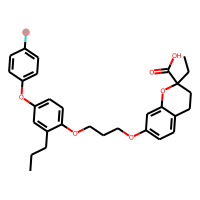
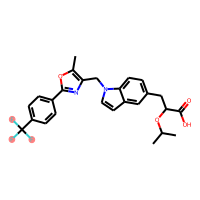
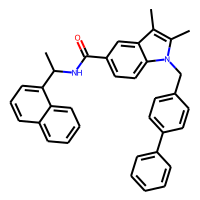
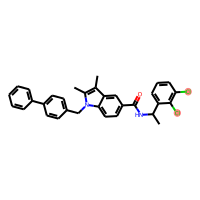
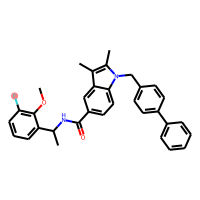

In [150]:
# create PCA for the PPAR dataset and the drug bank dataset
# combine the two dataframes, the first one is the PPAR dataset, the second one is the drug bank dataset, resign the index to avoid duplicate index values
dataframe = pd.concat([df_ppar, df_drugbank], axis=0, ignore_index=True) # combine the two dataframes, the first one is the PPAR dataset, the second one is the drug bank dataset
dataframe

In [151]:

x = dataframe.loc[:, featureList].values
y = dataframe.loc[:, ['label']].values

x = StandardScaler().fit_transform(x) # standardize the data, this is important for PCA, otherwise the results will be biased by the scale of the features

pca = PCA(n_components=2)

principalComponents = pca.fit_transform(x)

variance = pca.explained_variance_ratio_
principalDF = pd.DataFrame(data=principalComponents, columns=['PC1', 'PC2'])
principalDF


,PC1,PC2
0,0.566991,-1.270280
1,0.232500,-1.470992
2,0.247086,-3.823145
3,-0.095355,-3.619648
4,0.191838,-3.015944
...,...,...
3037,-1.425013,3.924810
3038,-2.312409,1.200287
3039,1.562891,-0.452858
3040,10.422942,6.219456


In [152]:

pcaDF = pd.concat([principalDF, dataframe[['label']]], axis=1)

loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2'], index=featureList)
print(loadings)

                   PC1       PC2
N             0.180340  0.023918
O             0.334743  0.200888
chiral        0.191559  0.267622
MW            0.389083 -0.187509
heavy_atoms   0.386497 -0.218409
h_acc         0.355108  0.208074
h_don         0.256981  0.269457
logP         -0.011428 -0.440794
TPSA          0.359239  0.238868
numAro        0.133683 -0.414043
formalCharge -0.010187  0.006204
numRings      0.243211 -0.245168
frac_csp3     0.011404  0.320970
S             0.032617  0.052596
nHalogens     0.002630 -0.180460
MR            0.343966 -0.259609


In [153]:
#define the function for plotting pca results
def plot_pca(pcaDF,variance,databases,colors):
    plt.rcParams['font.family'] = 'STIXGeneral'
    plt.rcParams['figure.figsize'] = 5, 5
    fig = plt.figure(dpi=300)
    axes = fig.add_subplot()
    axes.set_xlabel('PC1 ({:.2%})'.format(variance[0]), fontsize=16)
    axes.set_ylabel('PC2 ({:.2%})'.format(variance[1]), fontsize=16)

    for database, color in zip(databases, colors):
        indicesToKeep = pcaDF['label'] == database
        axes.scatter(pcaDF.loc[indicesToKeep, 'PC1'], pcaDF.loc[indicesToKeep, 'PC2'], c=color, s=5,alpha=0.8)
    axes.legend(databases, fontsize=15, loc='upper left', scatterpoints=5)

    plt.tick_params(labelsize=12)

    axes.set_yticks([-5,0,5,10,15])
    axes.set_xticks([-5,0,5,10,15])
 
    plt.tight_layout()
    plt.show()


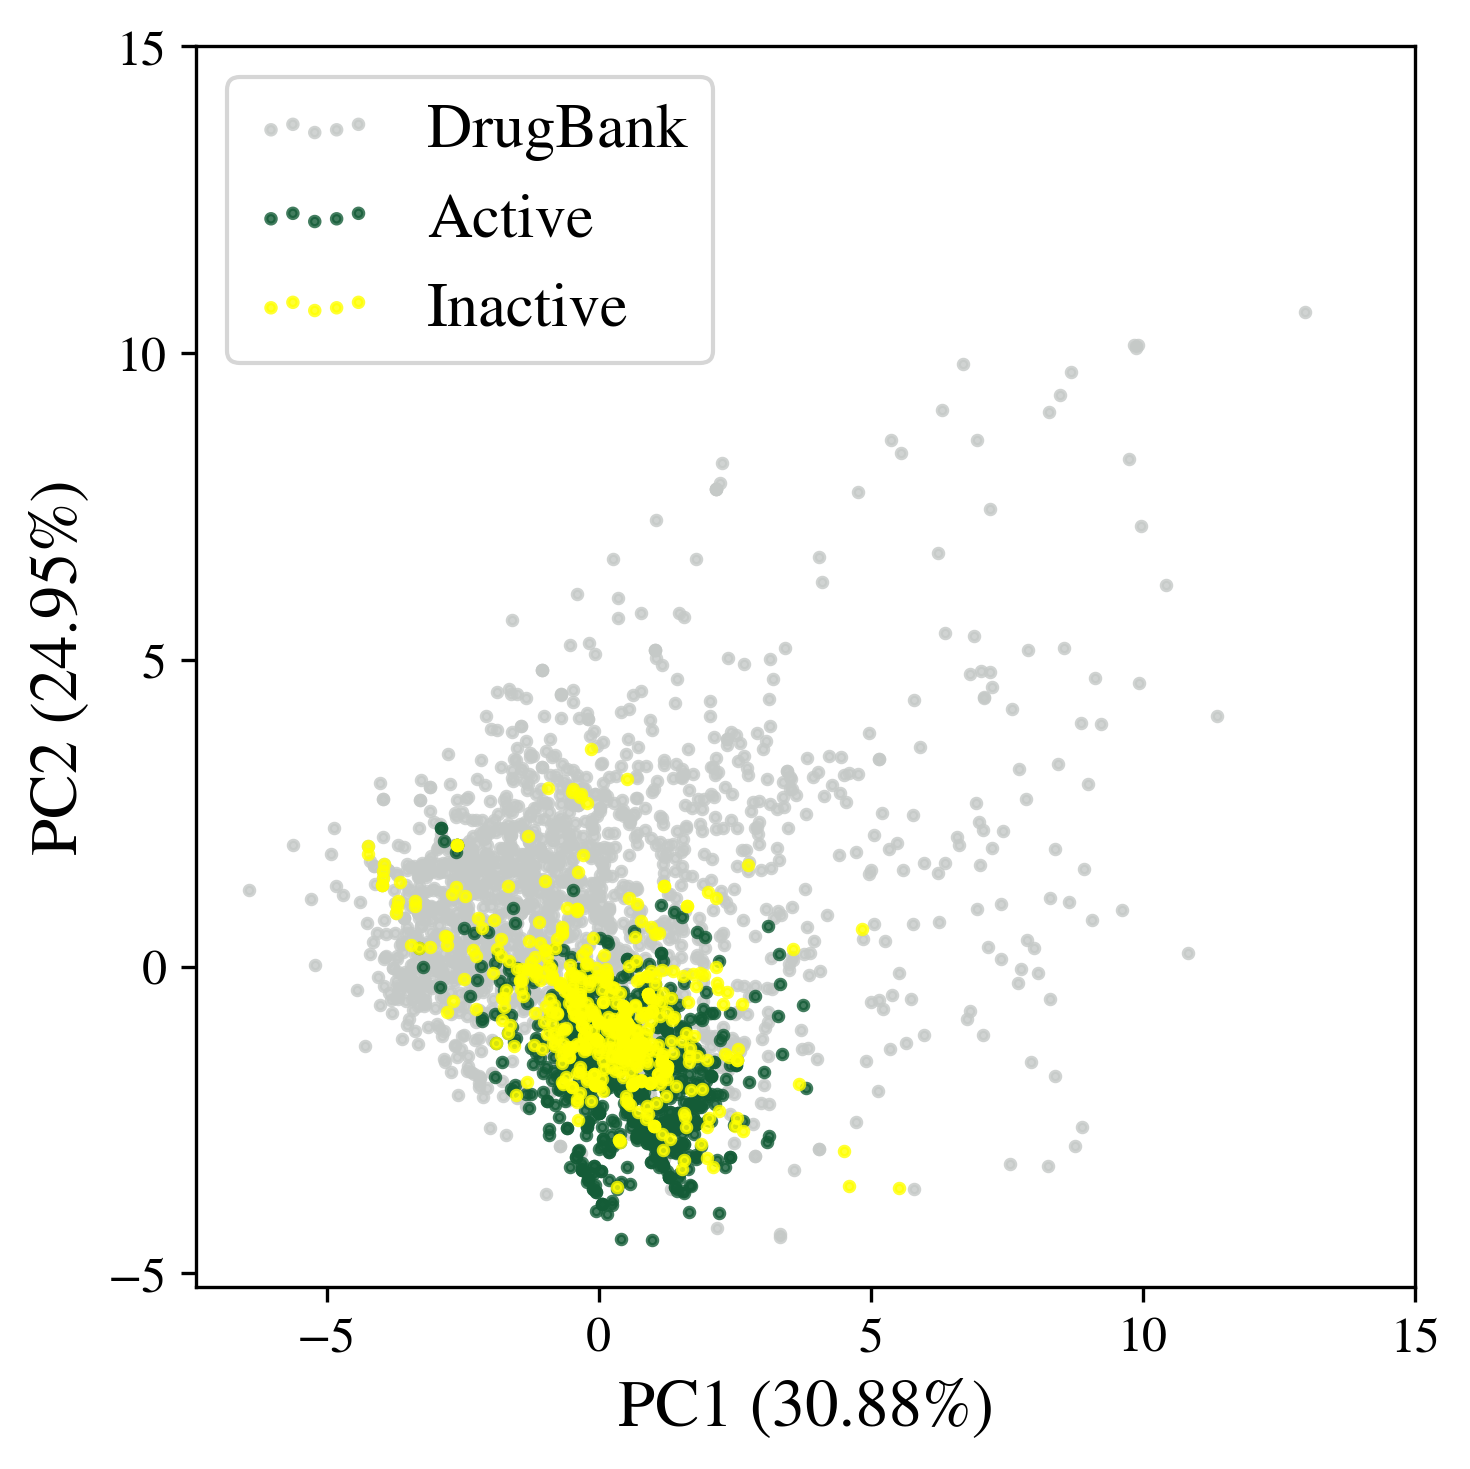

In [154]:
# plot the PCA results
plot_pca(pcaDF,variance,[ 'DrugBank', 'Active', 'Inactive'],['#c5c9c7','#145c37', 'yellow']) # Test whatever color code you want!

### Step 4: Preprocess the data, generate fingerprints as features

,preprocessedSmiles,Molecule ChEMBL ID,y_true_label,Molecule,N,O,chiral,MW,heavy_atoms,h_acc,...,TPSA,numAro,formalCharge,numRings,frac_csp3,S,nHalogens,MR,label,fingerprint
0,CCCc1cc(Oc2ccc(F)cc2)ccc1OCCCOc1ccc2c(c1)OC(CC...,CHEMBL111271,0,,0,6,1,508.586,37,5,...,74.22,18,0,4,0.367,0,1,138.567,Inactive,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
1,Cc1oc(-c2ccc(C(F)(F)F)cc2)nc1Cn1ccc2cc(CC(OC(C...,CHEMBL2037081,1,,2,4,1,486.490,35,5,...,77.49,20,0,4,0.308,0,3,124.067,Active,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,Cc1c(C)n(Cc2ccc(-c3ccccc3)cc2)c2ccc(C(=O)NC(C)...,CHEMBL3695875,1,,2,1,1,508.665,39,2,...,34.03,31,0,6,0.139,0,0,162.221,Active,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,Cc1c(C)n(Cc2ccc(-c3ccccc3)cc2)c2ccc(C(=O)NC(C)...,CHEMBL3695892,1,,2,1,1,527.495,37,2,...,34.03,27,0,5,0.156,0,2,154.735,Active,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,COc1c(F)cccc1C(C)NC(=O)c1ccc2c(c1)c(C)c(C)n2Cc...,CHEMBL3695898,1,,2,2,1,506.621,38,3,...,43.26,27,0,5,0.182,0,1,151.225,Active,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."

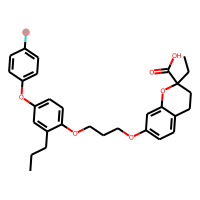
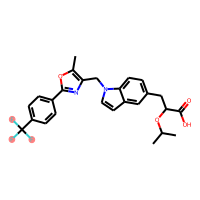
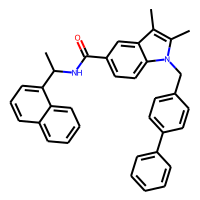
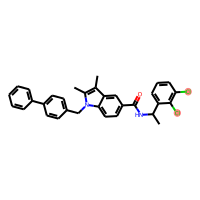
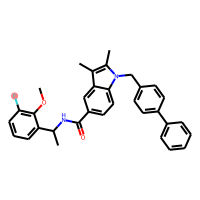

In [155]:
# Define a function for generating Morgan fingerprints for each molecule
def mol2fingerprint(mol):
    # Generate Morgan fingerprint
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048)
    arr = np.zeros((1,), dtype=np.int8)
    ConvertToNumpyArray(fp, arr)
    return arr

# Apply the function, generate Morgan fingerprints for each molecule in the dataset
df_ppar['fingerprint'] = df_ppar['preprocessedSmiles'].apply(lambda x: mol2fingerprint(Chem.MolFromSmiles(x)))

# Check the first few rows of the dataframe
df_ppar.head(5)

/tmp/ipykernel_162725/2725541945.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_ppar[morgan2_cols] = df_ppar.fingerprint.to_list()
/tmp/ipykernel_162725/2725541945.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_ppar[morgan2_cols] = df_ppar.fingerprint.to_list()
/tmp/ipykernel_162725/2725541945.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. 

,preprocessedSmiles,Molecule ChEMBL ID,y_true_label,Molecule,N,O,chiral,MW,heavy_atoms,h_acc,...,morgan2_b2038,morgan2_b2039,morgan2_b2040,morgan2_b2041,morgan2_b2042,morgan2_b2043,morgan2_b2044,morgan2_b2045,morgan2_b2046,morgan2_b2047
0,CCCc1cc(Oc2ccc(F)cc2)ccc1OCCCOc1ccc2c(c1)OC(CC...,CHEMBL111271,0,,0,6,1,508.586,37,5,...,0,0,0,0,0,0,0,0,0,0
1,Cc1oc(-c2ccc(C(F)(F)F)cc2)nc1Cn1ccc2cc(CC(OC(C...,CHEMBL2037081,1,,2,4,1,486.490,35,5,...,0,0,0,0,0,0,0,0,0,0
2,Cc1c(C)n(Cc2ccc(-c3ccccc3)cc2)c2ccc(C(=O)NC(C)...,CHEMBL3695875,1,,2,1,1,508.665,39,2,...,0,0,0,0,0,0,0,0,0,0
3,Cc1c(C)n(Cc2ccc(-c3ccccc3)cc2)c2ccc(C(=O)NC(C)...,CHEMBL3695892,1,,2,1,1,527.495,37,2,...,0,0,0,0,0,0,0,0,0,0
4,COc1c(F)cccc1C(C)NC(=O)c1ccc2c(c1)c(C)c(C)n2Cc...,CHEMBL3695898,1,,2,2,1,506.621,38,3,...,0,0,0,0,0,0,0,0,0,0

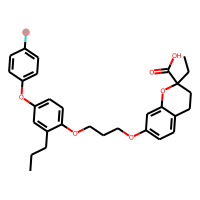
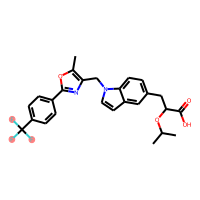
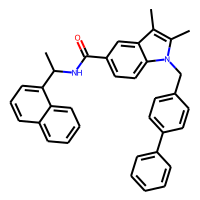
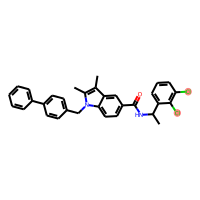
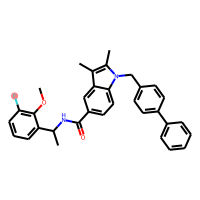

In [156]:
# split the fingerprint into different columns，as each bit is a separate feature
morgan2_cols = ['morgan2_b'+str(i) for i in list(range(2048))]
df_ppar[morgan2_cols] = df_ppar.fingerprint.to_list()
df_ppar.head(5)

### Step 5: Train and Evaluate ML Model (Random Forest)

In [157]:
# split the dataset into training and test sets, with stratification based on the y_true_label
train_df, test_df = train_test_split(df_ppar, test_size=0.2, random_state=42, stratify=df_ppar['y_true_label'])

In [158]:
# Make sure morgan2_cols is defined
morgan2_cols = ['morgan2_b'+str(i) for i in list(range(2048))]
X_train = train_df[morgan2_cols] 
y_train = train_df.y_true_label
X_test = test_df[morgan2_cols]
y_test = test_df.y_true_label


In [159]:
# Train the RF mdodel
rf = RandomForestClassifier(n_estimators=50, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=50, random_state=42)

<Figure size 1000x800 with 0 Axes>

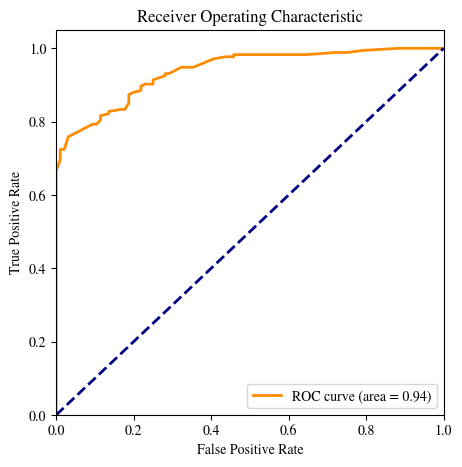

In [160]:
# Initialize a figure for plotting
plt.figure(figsize=(10, 8))
model = rf

# Predict probabilities for the positive class
y_pred_prob = model.predict_proba(test_df[morgan2_cols])[:, 1]

# Calculate the ROC curve points and AUC
fpr, tpr, thresholds = roc_curve(test_df['y_true_label'], y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### Step 6: Screening the DrugBank database

In [161]:
# generate the predictions for the drug bank database, before that, we need to generate the fingerprints for the drug bank database
df_drugbank['fingerprint'] = df_drugbank['preprocessedSmiles'].apply(lambda x: mol2fingerprint(Chem.MolFromSmiles(x)))
df_drugbank[morgan2_cols] = df_drugbank.fingerprint.to_list()
X = df_drugbank[morgan2_cols]
predictions_proba = model.predict_proba(X)[:, 1]
df_drugbank['Predicted_result'] = predictions_proba


/tmp/ipykernel_162725/623243033.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_drugbank[morgan2_cols] = df_drugbank.fingerprint.to_list()
/tmp/ipykernel_162725/623243033.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_drugbank[morgan2_cols] = df_drugbank.fingerprint.to_list()
/tmp/ipykernel_162725/623243033.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis

,preprocessedSmiles,DATABASE_ID,N,O,chiral,MW,heavy_atoms,h_acc,h_don,logP,...,morgan2_b2040,morgan2_b2041,morgan2_b2042,morgan2_b2043,morgan2_b2044,morgan2_b2045,morgan2_b2046,morgan2_b2047,Predicted_result,mol
0,C[S+](CCC(N)C(=O)O)C[C@H]1O[C@@H](n2cnc3c(N)nc...,DB00118,6,5,6,399.453,27,10,5,-1.922,...,0,0,0,0,0,0,0,0,0.180,
1,Nc1ncnc2c1ncn2[C@@H]1O[C@H](CO[PH](=O)(=O)O)[C...,DB00131,5,7,4,347.224,23,11,4,-1.693,...,0,0,0,0,0,0,0,0,0.260,
2,CC/C=C\C/C=C\C/C=C\CCCCCCCC(=O)O,DB00132,0,2,0,278.436,20,1,1,5.661,...,0,0,0,0,0,0,0,0,0.020,
3,C=C1/C(=C\C=C2/CCC[C@@]3(C)[C@H]2CC[C@@H]3[C@H...,DB00136,0,3,6,416.646,30,3,3,5.705,...,0,0,0,0,0,0,0,0,0.275,
4,CC1=C[C@H](O)CC(C)(C)[C@H]1/C=C/C(C)=C/C=C/C(C...,DB00137,0,2,3,568.886,42,2,2,10.403,...,0,0,0,0,0,0,0,0,0.220,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1687,O=[PH](=O)(O)C(O)(Cn1ccnc1)[PH](=O)(=O)O,DB16907,2,7,0,272.090,16,7,3,-0.774,...,0,0,0,0,0,0,0,0,0.220,
1688,CCNCc1nc2c(O)c(Cl)cc(Cl)c2c(=O)n1C,DB16965,3,2,0,302.161,19,5,2,2.055,...,0,0,0,0,0,0,0,0,0.320,
1689,COc1cc(F)c(-n2c(=O)[nH]c3csc(C(=O)O)c3c2=O)cc1...,DB17083,2,7,0,508.430,35,8,2,3.452,...,0,0,0,0,0,0,0,0,0.340,
1690,O=C(CCC(C(=O)O)N1CCN(C(CCC(=O)NCC(O)CO)C(=O)O)...,DB17084,7,15,6,815.875,57,16,12,-4.890,...,0,0,0,0,0,0,0,0,0.320,

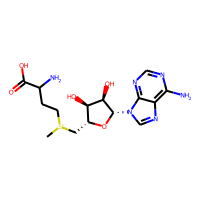
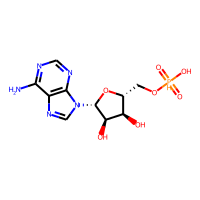
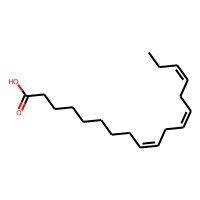
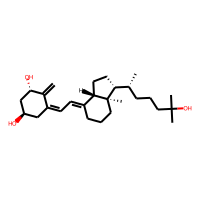
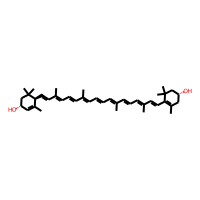
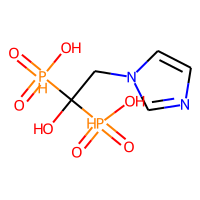
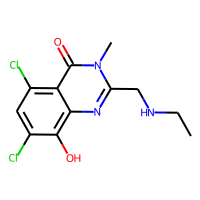
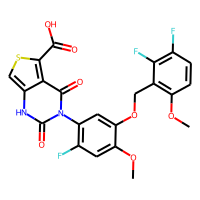
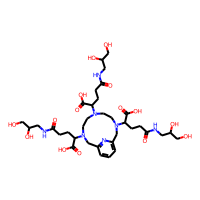
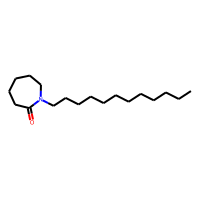

In [162]:
# add rdkit molecule object to the drug bank dataframe for visualization
df_drugbank = df_drugbank.assign(mol=df_drugbank['preprocessedSmiles'].apply(Chem.MolFromSmiles))   
df_drugbank

,DATABASE_ID,mol,Predicted_result
1533,DB13783,,0.80
1332,DB11574,,0.78
123,DB00328,,0.76
1002,DB06401,,0.74
1414,DB12001,,0.70
284,DB00549,,0.70
922,DB04847,,0.70
586,DB01012,,0.68
1350,DB11629,,0.66
410,DB00737,,0.66

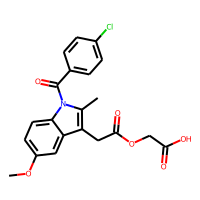
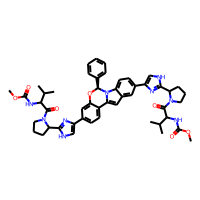
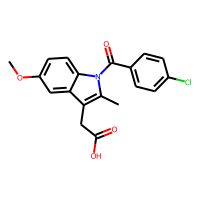
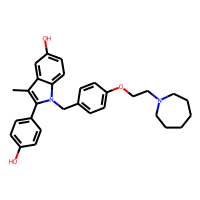
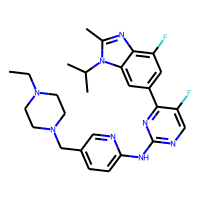
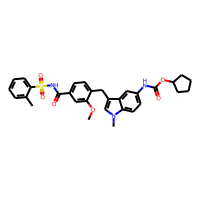
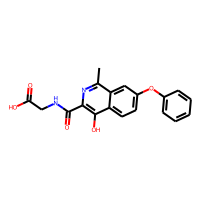
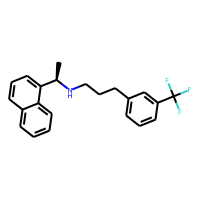
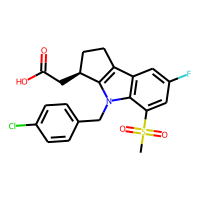
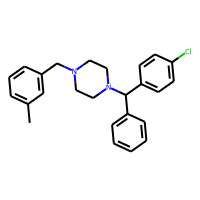
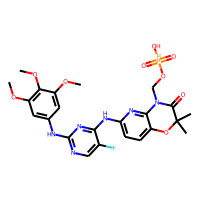
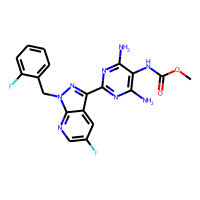
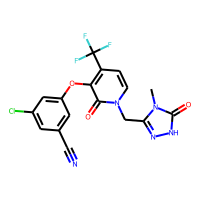
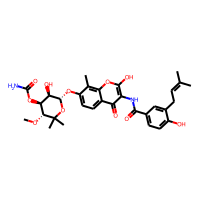
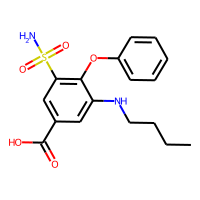
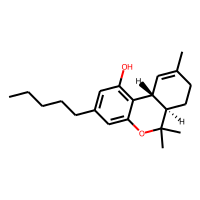
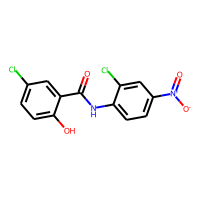
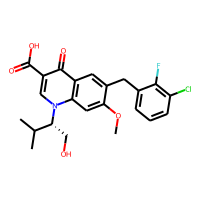
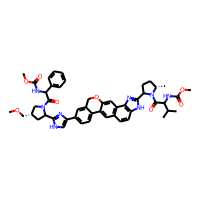
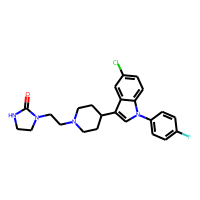

In [165]:
# Check the top 20 predictions
df_drugbank[['DATABASE_ID','mol', 'Predicted_result']].sort_values(by='Predicted_result', ascending=False).head(20)
# check the database_id from the drugbank website: https://go.drugbank.com/
# does your model suggest any useful/interesting compounds? :) 

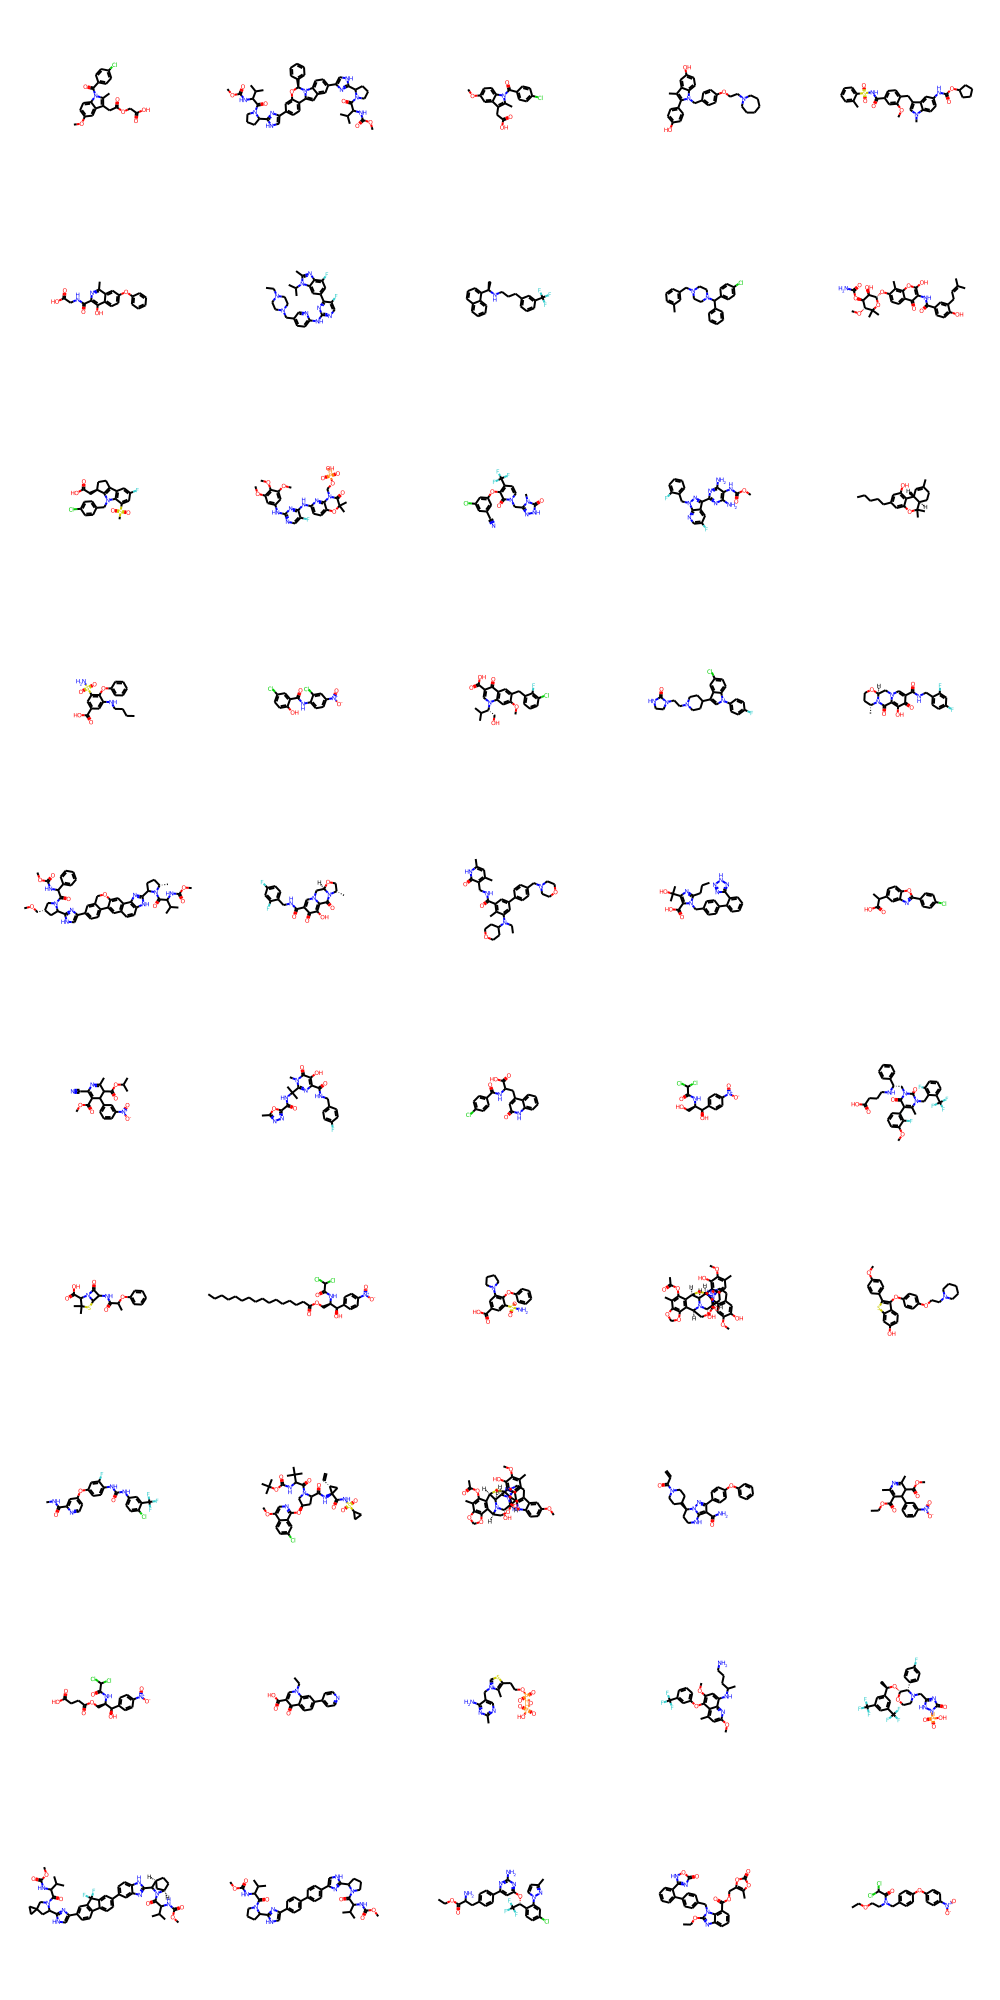

In [167]:
# show the top 20 predictions in rdkit gird
def show_top_50_predictions(df, column):
    # Get the top 50 predictions
    top_50 = df.nlargest(50, column)
    
    # Create a list of molecules
    mols = [Chem.MolFromSmiles(smiles) for smiles in top_50['preprocessedSmiles']]
    
    # Draw the molecules in a grid
    img = Draw.MolsToGridImage(mols, molsPerRow=5, subImgSize=(200, 200))
    
    return img
# Display the top 20 predictions
img = show_top_50_predictions(df_drugbank, 'Predicted_result')
img

In [173]:
# KNN instead of RF
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

KNeighborsClassifier()

<Figure size 1000x800 with 0 Axes>

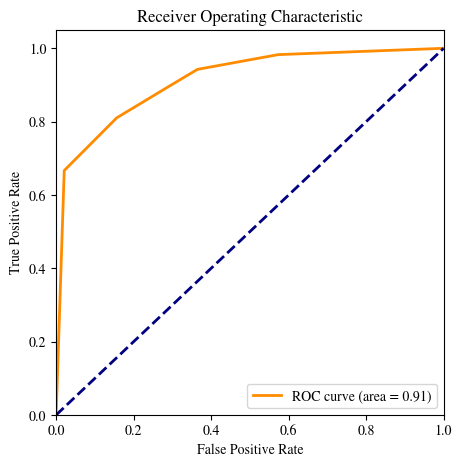

In [174]:
# Initialize a figure for plotting
plt.figure(figsize=(10, 8))
model = knn

# Predict probabilities for the positive class
y_pred_prob = model.predict_proba(test_df[morgan2_cols])[:, 1]

# Calculate the ROC curve points and AUC
fpr, tpr, thresholds = roc_curve(test_df['y_true_label'], y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [170]:
# XGBoost instead of RF

from xgboost import XGBClassifier
xgb = XGBClassifier(n_estimators=50, random_state=42)
xgb.fit(X_train, y_train) 

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

<Figure size 1000x800 with 0 Axes>

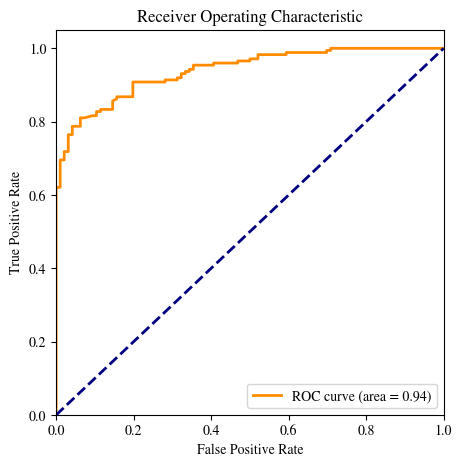

In [171]:
# Initialize a figure for plotting
plt.figure(figsize=(10, 8))
model = xgb

# Predict probabilities for the positive class
y_pred_prob = model.predict_proba(test_df[morgan2_cols])[:, 1]

# Calculate the ROC curve points and AUC
fpr, tpr, thresholds = roc_curve(test_df['y_true_label'], y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()